In [9]:
import os
import time
import logging
import argparse
import numpy as np
from tqdm import tqdm
import scipy.io as sio
from copy import deepcopy
from einops import rearrange
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects


import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torch.optim.adam import Adam
import torch.backends.cudnn as cudnn
from timm.models.vision_transformer import PatchEmbed, Block


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


from data_prepare import mirror_hsi
from data_prepare import choose_all_pixels, all_data
from data_prepare import choose_pretrain, pretrain_data
from data_prepare import choose_train_and_test, train_and_test_data, train_and_test_label


from CNNUtils import train, test, valid
from Utils import plot_confusion_matrix, print_args
from Utils import output_metric, classification_map, list_to_colormap


%matplotlib inline

In [10]:
parser = argparse.ArgumentParser("MCNN")
parser.add_argument('--dataset', choices=['HU2013', 'HanChuan', 'Salinas', 'KSC'], default='Salinas', help='dataset to use')
parser.add_argument('--gpu_id', default='0', help='GPU id')
parser.add_argument('--seed', type=int, default=42, help='number of the random seed')
parser.add_argument('--batch_size', type=int, default=128, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=15, help='size of patches')
parser.add_argument('--epoches', type=int, default=100, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--train_number', type=int, default=10, help='num_train_per_class')
parser.add_argument('--pretrain_proportion', type=float, default=0.5, help='proportion_pretrain_per_class')
args = parser.parse_args(args=[])

In [11]:
# prepare data
data_path = os.path.join(os.getcwd(), 'dataset')

if args.dataset == 'Salinas':
    data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
    label = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
elif args.dataset == 'HanChuan':
    data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
    label = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt.mat'))['WHU_Hi_HanChuan_gt']
elif args.dataset == 'HU2013':
    data = sio.loadmat(os.path.join(data_path, 'Houston.mat'))['Houston']
    label = sio.loadmat(os.path.join(data_path, 'Houston_gt.mat'))['Houston_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat(os.path.join(data_path, 'KSC.mat'))['KSC']
    label = sio.loadmat(os.path.join(data_path, 'KSC_gt.mat'))['KSC_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 16


In [12]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [13]:
def applyPCA(data, numComponents=30):
    new_data = np.reshape(data, (-1, data.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    new_data = pca.fit_transform(new_data)
    new_data = np.reshape(new_data, (data.shape[0], data.shape[1], numComponents))
    return new_data, pca

In [14]:
K = 15
data, pca = applyPCA(data, numComponents=K)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=217, band=15


## Dataloader Construction

In [15]:
total_pos_pretrain, y_pretrain = choose_pretrain(label, pretrain_proportion=args.pretrain_proportion, seed=args.seed)

mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

x_pretrain = pretrain_data(mirror_data, band, total_pos_pretrain, patch_size=args.patch_size)

*******************************************************
patch_size : 15
mirror_data shape : [526, 231, 15]
*******************************************************
x_pretrain shape : (27064, 15, 15, 15), type = float64
*******************************************************


In [16]:
# load data
x_pretrain = torch.from_numpy(x_pretrain.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (40908, 15, 15, 15)
y_pretrain = torch.from_numpy(y_pretrain).type(torch.LongTensor)  # (40908,)
print(x_pretrain.shape)
print(y_pretrain.shape)

pretrain_label = Data.TensorDataset(x_pretrain, y_pretrain)
pretrain_loader = Data.DataLoader(pretrain_label, batch_size=args.batch_size, shuffle=True)

torch.Size([27064, 15, 15, 15])
torch.Size([27064])


## Model

In [17]:
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M, )
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2, )  32

    pos = pos.reshape(-1)  # (M, )  169
    out = np.einsum('m, d -> md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=True):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)  # (H*W, D)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)  # (1+H*W, D)
    return pos_embed

In [18]:
class IMAB(nn.Module):
    "Multihead Attention Block"
    def __init__(self, dim_Q, dim_K, dim_hidden, num_heads):
        super(IMAB, self).__init__()
        self.dim_hidden = dim_hidden
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_hidden)
        self.fc_k = nn.Linear(dim_K, dim_hidden)
        self.fc_v = nn.Linear(dim_K, dim_hidden)
        self.fc_o = nn.Sequential(nn.Linear(dim_hidden, dim_Q), nn.Dropout(0.1))
        self.ln0 = nn.LayerNorm(dim_Q)
        self.ln1 = nn.LayerNorm(dim_K)
        self.ln2 = nn.LayerNorm(dim_Q)
        self.mlp = nn.Sequential(nn.Linear(dim_Q, 4*dim_Q), nn.GELU(), nn.Dropout(0.1), nn.Linear(4*dim_Q, dim_Q), nn.Dropout(0.1))

    def forward(self, Q, K):
        # LayerNorm
        Q_, K_ = self.ln0(Q), self.ln1(K)
        # Attention
        Q_, K_, V_ = self.fc_q(Q_), self.fc_k(K_), self.fc_v(K_)
        dim_head = self.dim_hidden // self.num_heads  # 64 // 4 = 16
        Q_ = torch.cat(Q_.split(dim_head, 2), 0)  # (4*B, K, 16) 
        K_ = torch.cat(K_.split(dim_head, 2), 0)  # (4*B, M, 16) 
        V_ = torch.cat(V_.split(dim_head, 2), 0)  # (4*B, M, 16) 
        A = torch.softmax(Q_.bmm(K_.transpose(1, 2)) / dim_head ** 0.5, 2)  # (4*B, K, M) 
        O = torch.cat(A.bmm(V_).split(Q.size(0), 0), 2)  # (B, K, 64)
        O = self.fc_o(O)
        # Residual
        O = Q + O
        # LayerNorm
        O_ = self.ln2(O)
        # Residual
        O = O + self.mlp(O_)
        return O  # (B, K, 128)


def random_masking(x, mask_ratio):
    N, L, D = x.shape  # batch, length, dim
    len_keep = int(L * (1 - mask_ratio))  
    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]  (N, L)
    # sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=1)  # 从小到大排序，返回索引 (N, L)
    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
    return x_masked

In [19]:
class LeavesEncoder(nn.Module):
    def __init__(self, img_size=15, in_chans=15, embed_dim=128):
        super(LeavesEncoder, self).__init__()
        self.patch_embed = nn.Conv2d(in_chans, embed_dim, 3, 1)  # (B, 128, 13, 13)
        self.num_patches = int((img_size - 3) / 1 + 1) ** 2  # 169
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim), requires_grad=False)  # (B, 169, 128)
        self.initialize_weights()

    def initialize_weights(self):
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.num_patches**.5), cls_token=False)  # (169, 128)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))  # (1, 170, 128)
        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))  # (embed_dim, in_chans, patch_size, patch_size)  (128, 1, 3, 3)

    def forward(self, imgs, mask_ratio=0.75):
        x = self.patch_embed(imgs)  # (B, 128, 13, 13)
        x = rearrange(x, 'b c h w -> b (h w) c')  # (B, 169, 128)
        # add pos embed w/o cls token
        x = x + self.pos_embed  # (B, 169, 128)
        if self.training:
            x = random_masking(x, mask_ratio)  # (B, 84, 128)
        return x


class InternalsEncoder(nn.Module):
    def __init__(self, dim_input=128, embed_dim=128):
        super(InternalsEncoder, self).__init__()
        self.n_internals = int((13 - 3) / 2 + 1) ** 2  # 36
        self.I = nn.Parameter(torch.zeros(1, 1, embed_dim))  # (1, 1, 128)
        self.internals_embed = IMAB(embed_dim, dim_input, dim_hidden=64, num_heads=4)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_internals, embed_dim), requires_grad=False)  # (B, 36, 128)
        self.initialize_weights()

    def initialize_weights(self):
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.n_internals**.5), cls_token=False)  # (36, 128)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))  # (1, 36, 128)
        nn.init.xavier_uniform_(self.I)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, mask_ratio=0.75):
        internals_tokens = self.I.repeat(x.shape[0], self.n_internals, 1)  # (B, 36, 128)
        internals_tokens = internals_tokens + self.pos_embed
        # Inducing Internals
        x = self.internals_embed(internals_tokens, x)  # (B, 36, 128)
        if self.training:
            x = random_masking(x, mask_ratio)  # (B, 9, 128)
        return x


class TopsEncoder(nn.Module):
    def __init__(self, dim_input=128, embed_dim=128):
        super(TopsEncoder, self).__init__()
        self.n_tops = int((6 - 3) / 1 + 1) ** 2  # 16
        self.I = nn.Parameter(torch.zeros(1, 1, embed_dim))  # (1, 1, 128)
        self.tops_embed = IMAB(embed_dim, dim_input, dim_hidden=64, num_heads=4)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_tops, embed_dim), requires_grad=False)  # (B, 16, 128)
        self.initialize_weights()

    def initialize_weights(self):
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.n_tops**.5), cls_token=False)  # (16, 128)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))  # (1, 16, 128)
        nn.init.xavier_uniform_(self.I)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, mask_ratio=0.75):
        tops_tokens = self.I.repeat(x.shape[0], self.n_tops, 1)  # (B, 16, 128)
        tops_tokens = tops_tokens + self.pos_embed
        # Inducing Tops
        x = self.tops_embed(tops_tokens, x)  # (B, 16, 128)
        if self.training:
            x = random_masking(x, mask_ratio)  # (B, 4, 128)
        return x


class RootEncoder(nn.Module):
    def __init__(self, dim_input=128, depth=4, num_heads=8):
        super(RootEncoder, self).__init__()
        self.norm = nn.LayerNorm(dim_input)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim_input))
        self.cls_tokens_pos_embed = nn.Parameter(torch.zeros(1, 1, dim_input), requires_grad=False)
        nn.init.normal_(self.cls_token, std=.02)
        self.blocks = nn.ModuleList([Block(dim_input, num_heads, qkv_bias=True) for _ in range(depth)])
        
    def forward(self, x):
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1) + self.cls_tokens_pos_embed  # (B, 1, 128)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, 1+4, 128)
        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        x = x[:, 0, :]
        return x

In [20]:
class Decoder(nn.Module):
    def __init__(self, output_shape=[15, 15, 15], root_dim=128):
        super(Decoder, self).__init__()
        self.output_shape = output_shape
        self.root_dim = root_dim
        self.fc = nn.Sequential(nn.Linear(self.root_dim, 32*3*3), nn.BatchNorm1d(32*3*3), nn.ReLU())
        self.trans_conv = nn.Sequential(nn.ConvTranspose2d(32, 128, 3, stride=1), nn.BatchNorm2d(128), nn.ReLU(), # (..., 5, 5)
                                        nn.ConvTranspose2d(128, 64, 3, stride=1), nn.BatchNorm2d(64), nn.ReLU(), # (..., 7, 7)
                                        nn.ConvTranspose2d(64, self.output_shape[0], 3, stride=2))  # (batch_size, 15, 15, 15)
        
    def forward(self, codings_in_batch_order):  # x: (batch, 38)
        h = self.fc(codings_in_batch_order)
        h = h.view(-1, 32, 3, 3)
        return self.trans_conv(h)


class MaskedTree(nn.Module):
    def __init__(self, input_shape=[15, 15, 15], root_dim=128):
        super(MaskedTree, self).__init__()
        self.leaves_encoder = LeavesEncoder()
        self.internals_encoder = InternalsEncoder()
        self.tops_encoder = TopsEncoder()
        self.roots_encoder = RootEncoder()
        self.decoder = Decoder(input_shape, root_dim)

    def forward(self, imgs):
        leaves = self.leaves_encoder(imgs)
        internals = self.internals_encoder(leaves)
        tops = self.tops_encoder(internals)
        codings = self.roots_encoder(tops)
        recons = self.decoder(codings)
        return recons, codings

In [21]:
def model_summary(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name+':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name+':', num_param)
            total_param += num_param
    print("\nTotal Trainable Parameters:", total_param)


class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0
    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt


def pretrain(model, criterion, train_loader, device):
    model.train()
    optimizer = Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    train_len = len(train_loader)
    path = './model/mcnn.pt'
    tic = time.time()
    for epoch in range(400):
        objs = AverageMeter()
        for batch_idx, (image, label) in tqdm(enumerate(train_loader)):
            image = image.to(device)
            optimizer.zero_grad()
            recons, _ = model(image)
            loss = criterion(recons, image)
            loss.backward()
            optimizer.step()
            n = image.shape[0]
            objs.update(loss.data, n)  
            if (batch_idx + 1) == len(train_loader):
                print('epoch: {}, loss: {:.4f}'.format(epoch+1, objs.avg))  
        scheduler.step()
    toc = time.time()
    print("Running Time: {:.2f}".format(toc-tic))
    torch.save(model.state_dict(), path)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

maskedtree = MaskedTree()
maskedtree = maskedtree.to(device)
criterion = nn.MSELoss()

In [23]:
model_summary(maskedtree)

leaves_encoder.patch_embed.weight: 128x15x3x3 = 17280
leaves_encoder.patch_embed.bias: 128
internals_encoder.I: 1x1x128 = 128
internals_encoder.internals_embed.fc_q.weight: 64x128 = 8192
internals_encoder.internals_embed.fc_q.bias: 64
internals_encoder.internals_embed.fc_k.weight: 64x128 = 8192
internals_encoder.internals_embed.fc_k.bias: 64
internals_encoder.internals_embed.fc_v.weight: 64x128 = 8192
internals_encoder.internals_embed.fc_v.bias: 64
internals_encoder.internals_embed.fc_o.0.weight: 128x64 = 8192
internals_encoder.internals_embed.fc_o.0.bias: 128
internals_encoder.internals_embed.ln0.weight: 128
internals_encoder.internals_embed.ln0.bias: 128
internals_encoder.internals_embed.ln1.weight: 128
internals_encoder.internals_embed.ln1.bias: 128
internals_encoder.internals_embed.ln2.weight: 128
internals_encoder.internals_embed.ln2.bias: 128
internals_encoder.internals_embed.mlp.0.weight: 512x128 = 65536
internals_encoder.internals_embed.mlp.0.bias: 512
internals_encoder.interna

In [ ]:
pretrain(maskedtree, criterion, pretrain_loader, device)

In [24]:
path = './model/mcnn.pt'

maskedtree.load_state_dict(torch.load(path))
maskedtree.eval()
print('done')

done


In [25]:
def scatter(x, colors, num_classes=15):
    palette = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [0, 255, 255], [255, 0, 255], [192, 192, 192], [128, 128, 128], 
                        [128, 0, 0], [128, 128, 0], [0, 128, 0], [128, 0, 128], [0, 128, 128], [0, 0, 128], [255, 165, 0], [255, 215, 0]])/255.
    
    # We create a scatter plot.
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int_)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    # We add the labels for each digit.
    txts = []
    for i in range(num_classes):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i+1), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)
    fig.savefig('./tsne_mcnn.pdf', bbox_inches='tight')

In [26]:
train_codings = []
train_tar = []
for batch_idx, (image, label) in enumerate(pretrain_loader):
    with torch.no_grad():
        image = image.to(device)
        label = label.to(device)
        return_tuple = maskedtree(image)
        codings = return_tuple[1]
    train_codings.append(codings.cpu().data)
    train_tar.append(label.cpu().data)

x_train = torch.concat(train_codings)
y_train = torch.concat(train_tar)

x_train_numpy = x_train.numpy()
y_train_numpy = y_train.numpy()

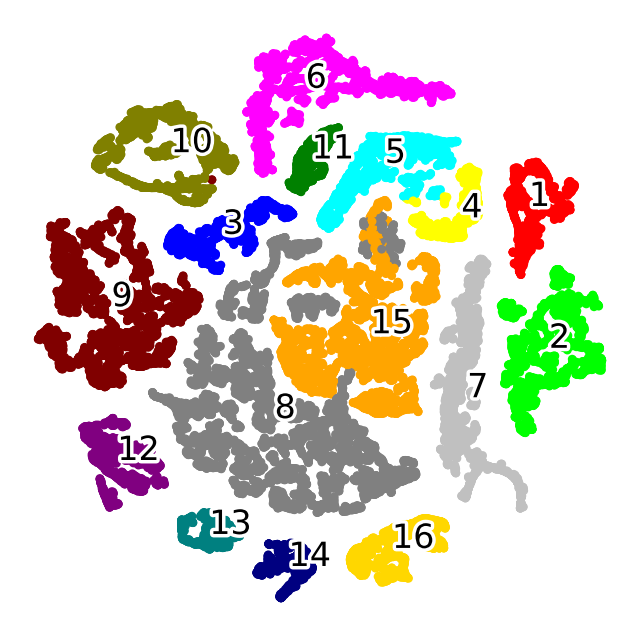

In [27]:
tsne_proj = TSNE(random_state=42).fit_transform(x_train_numpy)

scatter(tsne_proj, y_train_numpy, num_classes)

## Metrics

In [28]:
def mean_distance(codings, label, c=16):
    codings_per_class = []  # [(16, ) * 10]
    for i in range(c):
        codings_per_class.append(codings[label == i, :])
    centers = [torch.mean(codings_per_class[i], 0) for i in range(c)]
    
    inter_class_distance = torch.tensor(0.)
    for k in range(c - 1):
        for t in range(k + 1, c):
            inter_class_distance += torch.dist(centers[k], centers[t], p=2)
    mean_inter_class_distance = inter_class_distance / (c * (c - 1) / 2)
    
    intra_class_distance = torch.tensor(0.)
    for i in range(c):
        per_intra_class_distance = torch.tensor(0.)
        per_class_features = codings_per_class[i]
        center_feature = centers[i]
        num = per_class_features.size(0)
        for j in range(num):
            per_intra_class_distance += torch.dist(per_class_features[j], center_feature, p=2)
        per_intra_class_distance = per_intra_class_distance / num
        
        intra_class_distance += per_intra_class_distance
    mean_intra_class_distance = intra_class_distance / c
    return mean_intra_class_distance, mean_inter_class_distance

In [30]:
mean_intra_class_distance, mean_inter_class_distance = mean_distance(x_train, y_train, num_classes)

mean_intra_class_distance, mean_inter_class_distance

(tensor(1.1332), tensor(2.4413))

## Fine-tuning

In [31]:
class NewLeavesEncoder(LeavesEncoder):
    def forward(self, imgs):
        x = self.patch_embed(imgs)  # (B, 128, 13, 13)
        x = rearrange(x, 'b c h w -> b (h w) c')  # (B, 169, 128)
        # add pos embed w/o cls token
        x = x + self.pos_embed  # (B, 169, 128)
        return x


class NewInternalsEncoder(InternalsEncoder):
    def forward(self, x):
        internals_tokens = self.I.repeat(x.shape[0], self.n_internals, 1)  # (B, 36, 128)
        internals_tokens = internals_tokens + self.pos_embed
        # Inducing Internals
        x = self.internals_embed(internals_tokens, x)  # (B, 36, 128)
        return x


class NewTopsEncoder(TopsEncoder):
    def forward(self, x):
        tops_tokens = self.I.repeat(x.shape[0], self.n_tops, 1)  # (B, 16, 128)
        tops_tokens = tops_tokens + self.pos_embed
        # Inducing Tops
        x = self.tops_embed(tops_tokens, x)  # (B, 16, 128)
        return x


class NewMaskedTree(nn.Module):
    def __init__(self, input_shape=[15, 15, 15], root_dim=128, n_classes=13):
        super(NewMaskedTree, self).__init__()
        self.leaves_encoder = NewLeavesEncoder()
        self.internals_encoder = NewInternalsEncoder()
        self.tops_encoder = NewTopsEncoder()
        self.roots_encoder = RootEncoder()
        self.cls_head = nn.Sequential(nn.Linear(root_dim, 64), nn.ReLU(), nn.Dropout(0.2), nn.Linear(64, n_classes))

    def forward(self, x):
        leaves = self.leaves_encoder(x)
        internals = self.internals_encoder(leaves)
        tops = self.tops_encoder(internals)
        codings = self.roots_encoder(tops)
        preds = self.cls_head(codings)
        return preds

In [32]:
maskedtree = NewMaskedTree(n_classes=num_classes)

path = './model/mcnn.pt'
pre_weights = torch.load(path, map_location='cpu')
pre_dict = {k: v for k, v in pre_weights.items() if k in maskedtree.state_dict()}
missing_keys, unexpected_keys = maskedtree.load_state_dict(pre_dict, strict=False)

In [33]:
for param in maskedtree.parameters():
    param.requires_grad = False

for param in maskedtree.roots_encoder.blocks[-1].parameters():
    param.requires_grad = True

for param in maskedtree.cls_head.parameters():
    param.requires_grad = True

In [34]:
model_summary(maskedtree)

roots_encoder.blocks.3.norm1.weight: 128
roots_encoder.blocks.3.norm1.bias: 128
roots_encoder.blocks.3.attn.qkv.weight: 384x128 = 49152
roots_encoder.blocks.3.attn.qkv.bias: 384
roots_encoder.blocks.3.attn.proj.weight: 128x128 = 16384
roots_encoder.blocks.3.attn.proj.bias: 128
roots_encoder.blocks.3.norm2.weight: 128
roots_encoder.blocks.3.norm2.bias: 128
roots_encoder.blocks.3.mlp.fc1.weight: 512x128 = 65536
roots_encoder.blocks.3.mlp.fc1.bias: 512
roots_encoder.blocks.3.mlp.fc2.weight: 128x512 = 65536
roots_encoder.blocks.3.mlp.fc2.bias: 128
cls_head.0.weight: 64x128 = 8192
cls_head.0.bias: 64
cls_head.3.weight: 16x64 = 1024
cls_head.3.bias: 16

Total Trainable Parameters: 207568


In [35]:
maskedtree = maskedtree.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(maskedtree.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [36]:
if args.dataset == 'HU2013':
    label = sio.loadmat(os.path.join(data_path, 'Houston_gt.mat'))['Houston_gt']
elif args.dataset == 'HanChuan':
    label = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt.mat'))['WHU_Hi_HanChuan_gt']
elif args.dataset == 'KSC':
    label = sio.loadmat(os.path.join(data_path, 'KSC_gt.mat'))['KSC_gt']
elif args.dataset == 'Salinas':
    label = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']

In [37]:
total_pos_train, total_pos_test, total_pos_valid, number_train, number_test, number_valid = choose_train_and_test(label, args.train_number, args.seed) 

x_train, x_test, x_valid = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, total_pos_valid, args.patch_size)
y_train, y_test, y_valid = train_and_test_label(number_train, number_test, number_valid, num_classes)

*******************************************************
x_train shape = (160, 15, 15, 15), type = float64
x_test  shape = (53969, 15, 15, 15), type = float64
x_valid  shape = (1600, 15, 15, 15), type = float64
*******************************************************
y_train: shape = (160,), type = int64
y_test: shape = (53969,), type = int64
y_valid: shape = (1600,), type = int64
*******************************************************


In [38]:
total_pos_train[:10]

array([[268,  24],
       [245,  47],
       [242,  56],
       [263,  38],
       [243,  49],
       [246,  49],
       [257,  21],
       [243,  45],
       [247,  36],
       [245,  51]])

In [39]:
# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (90, 1, 7, 7, 176)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
train_label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5198, 1, 7, 7, 176)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
test_label = Data.TensorDataset(x_test, y_test)

x_valid = torch.from_numpy(x_valid.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5211, 1, 7, 7, 176)
print(x_valid.shape)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)
valid_label = Data.TensorDataset(x_valid, y_valid)

train_loader = Data.DataLoader(train_label, batch_size=32, shuffle=True)
test_loader = Data.DataLoader(test_label, batch_size=128, shuffle=True)
valid_loader = Data.DataLoader(valid_label, batch_size=32, shuffle=True)

torch.Size([160, 15, 15, 15])
torch.Size([53969, 15, 15, 15])
torch.Size([1600, 15, 15, 15])


In [40]:
tic = time.time()
acc_list = [0.00]
path = './model/finetune_mcnn.pt'

for epoch in range(args.epoches):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(maskedtree, train_loader, criterion, optimizer)
    valid_acc, valid_loss = valid(maskedtree, valid_loader, criterion)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to finetune_mcnn.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(maskedtree.state_dict(), path)
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        acc_list[-1] = acc_list[-2]
  
toc = time.time()
print("Training Time: {:.2f} seconds".format(toc-tic))
print("*******************************************************")

Epoch: 001 - train_loss: 2.8047 - train_acc: 3.1250 - valid_loss: 2.7573 - valid_acc: 8.8125
val_acc improved from 0.0000 to 8.8125, saving model to finetune_mcnn.pt
Epoch: 002 - train_loss: 2.7499 - train_acc: 8.7500 - valid_loss: 2.7120 - valid_acc: 13.2500
val_acc improved from 8.8125 to 13.2500, saving model to finetune_mcnn.pt
Epoch: 003 - train_loss: 2.6861 - train_acc: 18.1250 - valid_loss: 2.6548 - valid_acc: 32.4375
val_acc improved from 13.2500 to 32.4375, saving model to finetune_mcnn.pt
Epoch: 004 - train_loss: 2.6303 - train_acc: 35.6250 - valid_loss: 2.5882 - valid_acc: 52.1250
val_acc improved from 32.4375 to 52.1250, saving model to finetune_mcnn.pt
Epoch: 005 - train_loss: 2.5414 - train_acc: 51.8750 - valid_loss: 2.4992 - valid_acc: 55.8750
val_acc improved from 52.1250 to 55.8750, saving model to finetune_mcnn.pt
Epoch: 006 - train_loss: 2.4261 - train_acc: 57.5000 - valid_loss: 2.3740 - valid_acc: 59.8125
val_acc improved from 55.8750 to 59.8125, saving model to fin

## Testing

In [41]:
path = './model/finetune_mcnn.pt'

maskedtree.load_state_dict(torch.load(path))
maskedtree.eval()
print('done')

done


In [42]:
tar_test, pre_test = test(maskedtree, test_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [43]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")
print("Parameter:")
print_args(vars(args))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 92.88, AA: 96.82, Kappa: 0.9210
*******************************************************************
Recal: [ 97.65 100.    99.54  98.55  93.85 100.    97.09  76.65  97.97  97.49
  99.81  99.84 100.   100.    91.03  99.61]
*******************************************************************
Parameter:
dataset: Salinas
flag_test: train
gpu_id: 0
seed: 42
batch_size: 128
patch_size: 15
epoches: 100
learning_rate: 0.001
gamma: 0.99
train_number: 10
pretrain_proportion: 0.5
*******************************************************************


In [44]:
average_accuracy = str(list(AA_test))
file_name = "./CR/mcnn_1.txt"

with open(file_name, 'w') as x_file:
    x_file.write("[{:.2f}, {:.2f}, {:.4f}]".format(OA_test * 100., AA_mean_test*100., Kappa_test))
    x_file.write('\n')
    x_file.write('{}'.format(average_accuracy))

## Panoramic Classification

In [45]:
def output_label(model, loader):
    model.eval()
    pre = np.array([]).astype('int')
    with torch.no_grad():
        for batch_idx, (batch_data, batch_target) in enumerate(loader):
            batch_data = batch_data.cuda()
            batch_pred = model(batch_data)  # (B, 9)
            _, pred = batch_pred.topk(1, axis=1)  # (B, 1)
            pp = pred.squeeze()
            pre = np.append(pre, pp.data.cpu().numpy())
    return pre

In [46]:
pos_forward, pos_backward = choose_all_pixels(label)

x_forward, x_backward, y_forward, y_backward = all_data(mirror_data, band, pos_forward, pos_backward, patch_size=15)

*******************************************************
x_forward shape = (54129, 15, 15, 15), type = float64
x_backward  shape = (56975, 15, 15, 15), type = float64
*******************************************************


In [47]:
# load data
x_forward = torch.from_numpy(x_forward.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_forward.shape)
y_forward = torch.from_numpy(y_forward).type(torch.LongTensor)  # (13,)
forward_label = Data.TensorDataset(x_forward, y_forward)

x_backward = torch.from_numpy(x_backward.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_backward.shape)
y_backward = torch.from_numpy(y_backward).type(torch.LongTensor)  # (13,)
backward_label = Data.TensorDataset(x_backward, y_backward)

forward_loader = Data.DataLoader(forward_label, batch_size=128, shuffle=False)
backward_loader = Data.DataLoader(backward_label, batch_size=128, shuffle=False)

torch.Size([54129, 15, 15, 15])
torch.Size([56975, 15, 15, 15])


In [48]:
# output classification maps
pre_forward = output_label(maskedtree, forward_loader)
pre_backward = output_label(maskedtree, backward_loader)

prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(pos_forward.shape[0]):
    prediction_matrix[pos_forward[i, 0], pos_forward[i, 1]] = pre_forward[i] + 1

for j in range(pos_backward.shape[0]):
    prediction_matrix[pos_backward[j, 0], pos_backward[j, 1]] = pre_backward[j] + 1

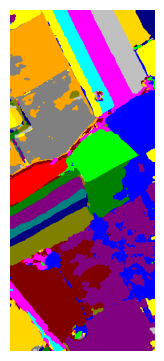

In [49]:
predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))

classification_map(predict_map, './salinas_mcnn.pdf')